Assignment 4: Natural Language Processing with Deep Learning

Name: Urchade Zaratiana
Matr. Num: k11932165

In [3]:
import torch

from dataset import NlpDataset
from models import AttentionBiLSTM, BertClassifier
from preprocessing import TextPreprocessor
from torch.utils.data import DataLoader
from torch import nn
from trainer import ClassifierTrainer
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from transformers import AutoTokenizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = 'cuda:0' if torch.cuda.is_available else 'cpu'

## Task 1: Document Classification

In [6]:
process_args = {
    'glove_path': r'word_embeddings/glove.6B.50d.txt',
    'data_path': r'data/thedeep.data.txt',
    'sequence_length': 70,
    'test_val_size': 3000
}

In [7]:
process = TextPreprocessor(**process_args)

Loading Spacy ....
Loading Glove ....
	- Number of vectors in Glove: 400000
	- Emdedding dim: 50
Splitting data ...
	- Length of train set: 9000
	- Length of test set: 1500
	- Length of validation set: 1500
Number of classes: 12
Creating word dicts ....
	- Length of the vocabulary (training set): 22874
	- Number of extracted vectors from Glove: 16621
	- Embedding weight shape: (22874, 50)


We have a dictionnary of 22979 words but only 16616 of them are present in glove. If a word in the dictionary is not found in Glove, it's vector is initialised randomly.

In [8]:
# Creating instance of NlpDataset, see dataset.py
train_data = NlpDataset(data=process.get_training_data())
val_data = NlpDataset(data=process.get_validation_data())
test_data = NlpDataset(data=process.get_test_data())

# Creating data loader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Our attenction odel is composed of an embedding layer, a Bidirectionnal RNN, a multi-head attention and a classifier layer.

We initilize the embedding layer with a 50-dimensional Glove (Pennington et al., 2014).
We use a bidirectionnal LSTM (Bi-LSTM) with an hidden_size of 128 to obtain a contextualised embedding of our input sequence. 
Our attention layer is multi-head attention (MHA) with 4 heads and an hidden size of 128*2 (the ouptut size of the Bi-LSTM).
Finally we feed the ouput of the MHA layer to a classifier (Linear layer + LogSoftmax activation).

Additionnally, we add some dropout layers inside our architecture (a dropout to the LSTM layer, MHA layer and one before the classifier layer).

In [9]:
# The baseline model arguments, see model.py
attention_model_args = {
    'n_classes': process.n_classes,
    'num_embeddings': process.num_words,
    'embedding_dim': process.embedding_dim,
    'weight': torch.FloatTensor(process.embedding_weight),
    'hidden_size': 128,
    'rnn_type': 'LSTM',
    'num_heads': 4,
    'rnn_dropout': 0.,
    'att_dropout': 0.4,
    'cls_dropout': 0.3,
}

In [10]:
att_model = AttentionBiLSTM(**attention_model_args).to(device)

We optimize the NLLLoss with adam optimizer with default learning rate.
During training, we use early stopping witch stops the training if the 
balanced_accuracy_score doesn't improve for 3 epochs.

In [11]:
trainer_args = {
    'model': att_model,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'loss_function': nn.NLLLoss(),
    'metric': balanced_accuracy_score,
    'optimizer':torch.optim.Adam
}

In [12]:
trainer = ClassifierTrainer(**trainer_args)

In [13]:
trainer.train(max_epoch=100, patience=3)

 16%|█▌        | 16/100 [00:53<04:41,  3.35s/it]

Early stopping ...


Here we train the model for 100 epochs and a patience of 2 for the early stopping

### Training curves

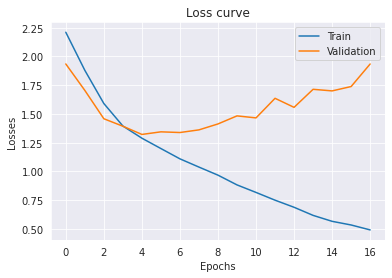

In [14]:
trainer.plot_loss_curve()

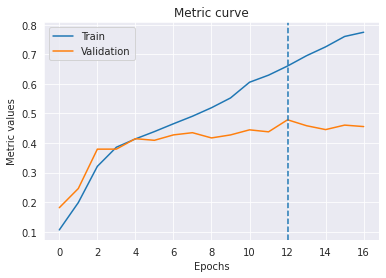

In [15]:
trainer.plot_metric_curve()

The vertical line indicates at witch epoch the best model have been saved.

In [16]:
# Loading the best model
trainer.model.load_state_dict(trainer.best_state_dict)

<All keys matched successfully>

We load the best model for the evaluation.

### Evaluation validation data

In [17]:
trainer.report_result(data_loader=val_loader)

              precision    recall  f1-score   support

           0       0.33      0.13      0.19        45
           1       0.28      0.32      0.30        59
           2       0.67      0.75      0.71        71
           3       0.57      0.64      0.60       253
           4       0.64      0.79      0.71       303
           5       0.39      0.23      0.29        98
           6       0.25      0.23      0.24        22
           7       0.26      0.21      0.23        57
           8       0.63      0.56      0.59        72
           9       0.66      0.65      0.65       252
          10       0.54      0.39      0.45       140
          11       0.54      0.57      0.55       128

    accuracy                           0.57      1500
   macro avg       0.48      0.46      0.46      1500
weighted avg       0.55      0.57      0.55      1500



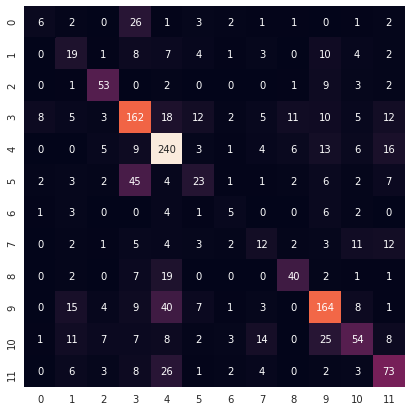

In [18]:
trainer.plot_cm(data_loader=val_loader)

### Evaluation on test data

#### Report table

In [19]:
trainer.report_result(data_loader=test_loader)

              precision    recall  f1-score   support

           0       0.41      0.20      0.27        44
           1       0.25      0.25      0.25        60
           2       0.76      0.66      0.71        71
           3       0.66      0.72      0.69       253
           4       0.64      0.80      0.71       303
           5       0.38      0.28      0.32        98
           6       0.20      0.22      0.21        23
           7       0.22      0.19      0.21        57
           8       0.69      0.54      0.60        71
           9       0.64      0.65      0.65       253
          10       0.52      0.42      0.46       139
          11       0.48      0.50      0.49       128

    accuracy                           0.58      1500
   macro avg       0.49      0.45      0.46      1500
weighted avg       0.56      0.58      0.57      1500



#### Confusion matrix

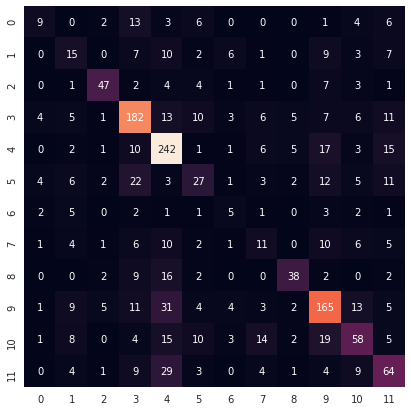

In [20]:
trainer.plot_cm(data_loader=test_loader)

Finally, we get 57% accuracy on the validation set and 58% on the test set.

# Task 3: BERT in Practice

We use pretrained DistillBert (an lightweight version of BERT; See Sanh et al., 2019) from HuggingFace library and 
we add one Linear layer and a logSoftmax layer on top of it.During training, we freeze the BERT layer and 
update only the classification layer.

In [21]:
# Model loading
bert_model = BertClassifier(model_name="distilbert-base-uncased", freeze_bert=True).to(device)

In [22]:
# Tokenizer loading
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [23]:
# Creating instance another instance of our dataset since we don't use the same tokenizer as the previous model.
train_bert = NlpDataset(data=process.get_training_data(bert=True, tokenizer=tokenizer))
val_bert = NlpDataset(data=process.get_validation_data(bert=True, tokenizer=tokenizer))
test_bert = NlpDataset(data=process.get_test_data(bert=True, tokenizer=tokenizer))

# Creating data loader
train_loader_bert = DataLoader(train_bert, batch_size=128, shuffle=True)
val_loader_bert = DataLoader(val_bert, batch_size=32)
test_loader_bert = DataLoader(test_bert, batch_size=32)

For the training, we use we optimize the Negative Log-Likelihood Loss by using an Adam optimizer with default learning rate (1e-3).
Moreover, we monitor balanced_accuracy_scor and we use it for the early stopping algorithm.

In [25]:
bert_trainer_args = {
    'model': bert_model,
    'train_loader': train_loader_bert,
    'val_loader': val_loader_bert,
    'loss_function': nn.NLLLoss(),
    'metric': balanced_accuracy_score,
    'optimizer':torch.optim.Adam
}

In [26]:
bert_trainer = ClassifierTrainer(**bert_trainer_args)

In [ ]:
bert_trainer.train(max_epoch=100, patience=3)

### Training curves

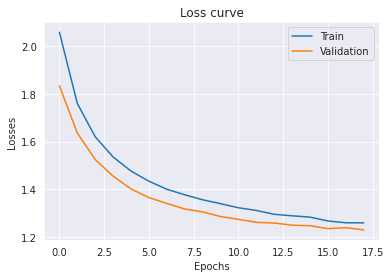

In [28]:
bert_trainer.plot_loss_curve()

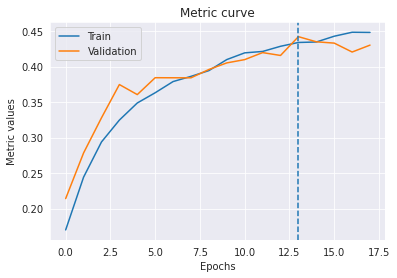

In [29]:
bert_trainer.plot_metric_curve()

In [30]:
# Loading the best model
trainer.model.load_state_dict(trainer.best_state_dict)

<All keys matched successfully>

### Evaluation validation data

In [32]:
bert_trainer.report_result(data_loader=val_loader_bert)

              precision    recall  f1-score   support

           0       0.21      0.07      0.10        45
           1       0.14      0.02      0.03        59
           2       0.74      0.70      0.72        71
           3       0.53      0.78      0.63       253
           4       0.79      0.82      0.80       303
           5       0.45      0.22      0.30        98
           6       1.00      0.09      0.17        22
           7       0.19      0.07      0.10        57
           8       0.78      0.40      0.53        72
           9       0.68      0.82      0.74       252
          10       0.47      0.61      0.53       140
          11       0.56      0.56      0.56       128

    accuracy                           0.61      1500
   macro avg       0.54      0.43      0.43      1500
weighted avg       0.59      0.61      0.58      1500



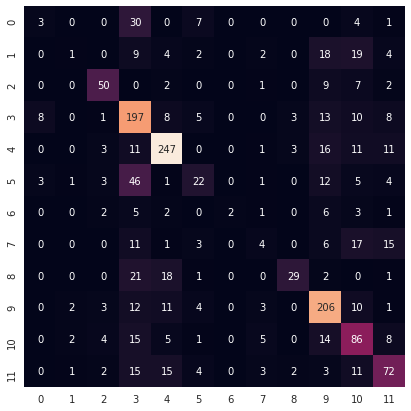

In [33]:
bert_trainer.plot_cm(data_loader=val_loader_bert)

### Evaluation on test data

#### Report table

In [34]:
bert_trainer.report_result(data_loader=test_loader_bert)

              precision    recall  f1-score   support

           0       0.67      0.14      0.23        44
           1       0.64      0.12      0.20        60
           2       0.83      0.70      0.76        71
           3       0.53      0.81      0.64       253
           4       0.77      0.83      0.80       303
           5       0.39      0.15      0.22        98
           6       0.62      0.22      0.32        23
           7       0.62      0.23      0.33        57
           8       0.75      0.38      0.50        71
           9       0.67      0.83      0.74       253
          10       0.48      0.62      0.54       139
          11       0.49      0.44      0.46       128

    accuracy                           0.62      1500
   macro avg       0.62      0.45      0.48      1500
weighted avg       0.62      0.62      0.59      1500



#### Confusion matrix

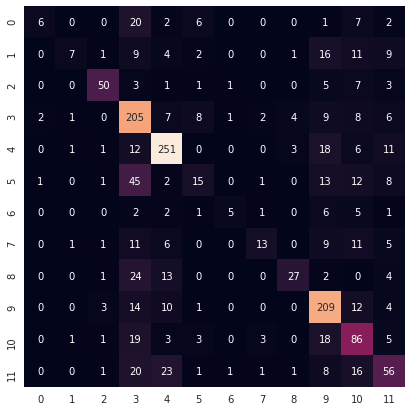

In [35]:
bert_trainer.plot_cm(data_loader=test_loader_bert)

We can see that we got a better result than Attenction model (62% VS 58%) and could get an higher accuracy by training longer
(the loss curve shows that the model is underfitting) or by unfreezing the BERT layer.